<img src="./img/HWNI_logo.svg"/>

# Lab 06a - Linear Algebra

In [1]:
# makes our plots show up inside Jupyter
%matplotlib notebook

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats

# choose colors that work for most color-blind folks
sns.set_palette("colorblind")
sns.set(color_codes=True)

import time

import util.lab05utils as utils 

# this makes our tables easier to read
utils.formatDataframes()

In [526]:
import cmath

def makeMesh(meshProps):
    numDimensions = 2
    
    mins = (meshProps['xMin'],meshProps['yMin'])
    maxs = (meshProps['xMax'],meshProps['yMax'])
    delta = meshProps['delta']
    
    for idx in range(numDimensions):
        assert mins[idx] < maxs[idx], "min can't be bigger than max!"
        
    ranges = [np.arange(mins[idx],maxs[idx]+delta,delta) for idx in range(numDimensions)]
    
    xs,ys = np.meshgrid(*ranges)
    
    return xs,ys

def plotMesh(f,ax,xs,ys,colors):
    ax.set_aspect('equal')
    h = plt.scatter(xs,ys,
                facecolor='black',alpha=0.7,
                    edgecolor='none',
                s=36,linewidth=2,
                zorder=6,
               c=colors,cmap='hot')
    
    return h

def plotVector(v,color,label=None):
    return plt.arrow(0,0,v[0],v[1],zorder=5,
              linewidth=6,color=color,head_width=0.1,label=label)
    
    
def plotInterestingVectors(T,columns=False,eigs=True):
    arrows = []
    labels = []
    if columns:
        arrows += [plotVector(column,'hotpink') 
                       for column in T.T]
        arrows = [arrows[0]]
        labels += ["a basis vector lands here"]
    if eigs:
        eigenvalues,eigenvectors = np.linalg.eig(T)
        eigenList = [(eigenvalue,eigenvector) for eigenvalue,eigenvector
                                    in zip(eigenvalues,eigenvectors.T)
                                  if eigenvalue != 0
                                      and not(np.iscomplex(eigenvalue))
                                      ]
        if eigenList:
            eigenArrows = [plotVector(np.real(element[1]),'#53fca1',label='special vectors')
                                 for element
                                     in eigenList
                                     ]
            eigenArrows = [eigenArrows[0]]
            labels += ["this is a special (aka eigen) vector"]
            arrows += eigenArrows
        else:
            print("eigenvalues are all nonreal or 0")
    plt.legend(arrows,labels,loc=[0,0.5],
               bbox_to_anchor=(0,1.05),
              ncol=2,prop={'weight':'bold'})
    return

def computeTrajectories(T,scatter):
    
    starting_positions = scatter.get_offsets()
    ending_positions = np.dot(T,starting_positions.T).T
    delta_positions = ending_positions-starting_positions
    
    return starting_positions,ending_positions,delta_positions

def setAxesLims(mn,mx,ax=None):
    if ax == None:
        ax = plt.gca()

    ax.set_ylim([mn,mx])
    ax.set_xlim([mn,mx])
    
    return

def calculateAxisBounds(starting_positions,ending_positions,bufferFactor=1.1):
    #axis bounds to include starting and ending positions of each point
    
    mn = bufferFactor*min(np.min(starting_positions),np.min(ending_positions))
    mx = bufferFactor*max(np.max(starting_positions),np.max(ending_positions))
    
    if mn == 0:
        mn -= 0.1
    if mx == 0:
        mx += 0.1
        
    return mn,mx

def drawCoordinateAxes(mn,mx,ax=None):
    if ax == None:
        ax = plt.gca()
    plt.hlines(0,mn,mx,zorder=4,linewidth=4,color='grey')
    plt.vlines(0,mn,mx,zorder=4,linewidth=4,color='grey')
    
    return

In [508]:
unitSquareMesh = {'delta':0.1,
                    'xMin' :0,
                    'xMax' : 1,
                    'yMin' : 0,
                    'yMax' : 1,}

foursquareMesh = {'delta':0.1,
                    'xMin' :-0.5,
                    'xMax' : 0.5,
                    'yMin' : -0.5,
                    'yMax' : 0.5,}

def setupPlot(T,meshProperties=unitSquareMesh,squareAxes=False,
             plotColumns=False,plotEigenvectors=False):
    """
    Setup the plot and axes for animating a linear transformation T.
    
    If asked, plot the columns (aka the images of the basis vectors)
        and the eigenvectors (but only if they're real and non-zero).
    
    Parameters
    ----------
    T        : 2x2 matrix representing a linear transformation
    meshProperties : dictionary that defines properties of meshgrid of points
                        that will be plotted and transformed.
                        needs to have the following five properties:
                        'delta' - mesh spacing
                        '{x,y}{Min,Max}' - minium/maximum value on x/y axis
    squareAxes : if False, size the axes so that they contain starting
                    and ending location of each point in grid.
                 if True, size the axes so that they are square and contain
                    starting and ending location of each point in mesh.
    plotColumns : if True, plot the columns of the transformation so that we can see
                        where the basis vectors end up
    plotEigenvectors: if true, plot the eigenvectors of the transformation
    
    Returns
    -------
    returns are meant to be consumed by animateTransformation
    
    scatter   : a PathCollection with all of the points in the meshgrid
    f         : matplotlib figure containing axes
    ax        : matplotlib axes containing scatter
    """
    T = np.asarray(T)
    
    xs,ys = makeMesh(meshProperties)
    colors = np.linspace(0,1,num=xs.shape[0]*xs.shape[1])
    
    f = plt.figure(figsize=(6,6))
    ax = plt.gca()
    
    scatter = plotMesh(f,ax,xs,ys,colors)
    
    plotVectors = [plotColumns,plotEigenvectors]
    
    notZeros = not(np.all(T == np.zeros(2)))
    
    if (any(plotVectors) & notZeros):
        plotInterestingVectors(T,*plotVectors)
    
    start,end,delta = computeTrajectories(T,scatter)
    
    mn,mx = calculateAxisBounds(start,end)
    
    if squareAxes:
        lim = max(abs(mn),abs(mx))
        mn = -lim; mx = lim
    
    drawCoordinateAxes(mn,mx)
    setAxesLims(mn,mx,ax=ax)

    f.canvas.draw()
    time.sleep(1)
    
    return scatter,f,ax
    

def animateTransformation(T,scatter,figure,
                          meshProperties=unitSquareMesh,
                          deltaT=0.05,delay=0.,):
    """
    Animate a linear transformation T acting on points scatter in figure.
    
    If asked, plot the columns (aka the images of the basis vectors)
        and the eigenvectors (but only if they're real and non-zero).
    
    Parameters
    ----------
    T        : 2x2 matrix representing a linear transformation
    meshProperties : dictionary that defines properties of meshgrid of points
                        that will be plotted and transformed.
                        needs to have the following five properties:
                        'delta' - mesh spacing
                        '{x,y}{Min,Max}' - minium/maximum value on x/y axis
    deltaT   : size of simulated timestep -- transformation complete at t = 1
    delay    : if non-zero, python will pause between frames of the animation for
                that many seconds.
    
    Returns
    -------
    returns are meant to be consumed by animateTransformation
    
    scatter   : a PathCollection with all of the points in the meshgrid
    f         : matplotlib figure containing axes
    ax        : matplotlib axes containing scatter
    """

    
    T = np.asarray(T)
    
    start,_,delta = computeTrajectories(T,scatter)
    
    I = np.eye(2)
    
    ts = np.arange(0,1+deltaT,deltaT)
    
    notZeros = not(np.all(T == np.zeros(2)))
    
    if ((T[0,0] == T[1,1]) & (T[0,1] == -1*T[1,0])) & \
            notZeros :
        
        z = complex(T[0,0],T[1,0])
        dz = z**(1/len(ts))
        
        dT = [[dz.real,-dz.imag],[dz.imag,dz.real]]
        for idx,t in enumerate(ts):
            current_positions = scatter.get_offsets()
            dT_toN = np.linalg.matrix_power(dT,idx+1)
            scatter.set_offsets(np.dot(dT_toN,start.T).T)
            figure.canvas.draw()
            if delay:
                time.sleep(delay)
                
    else:
        for idx,t in enumerate(ts):
            current_positions = scatter.get_offsets()
            scatter.set_offsets(t*(np.dot(T,start.T).T) +
                                   (1-t)*np.dot(I,start.T).T)

            figure.canvas.draw()
            if delay:
                time.sleep(delay)

In [509]:
scaling = [[3,0],[0,3]]
shear = [[1,2],[0,0.5]]

reflection = [[0,1],[1,0]]

rank0 = [[0,0],[0,0]]
rank1 = [[1,2],[1,2]]

R = makeRotation(theta=np.pi/2)

T = np.asarray([[1,3],
                [0,1]])

In [ ]:
transform = np.dot(R,np.diag([2,2]))
#transform = rank1
#transform = T

#transform = np.dot(np.dot(T,R),reflection)

mesh = unitSquareMesh

<IPython.core.display.Javascript object>


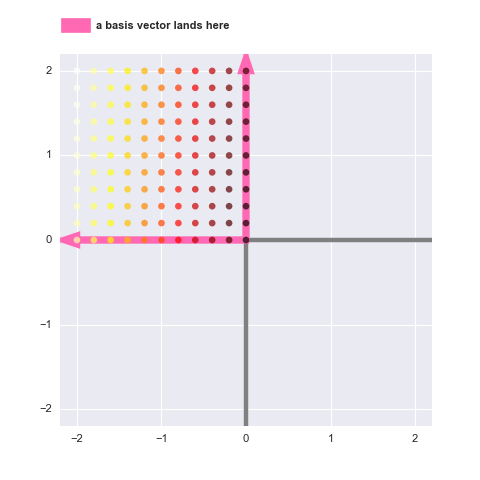

eigenvalues are all nonreal or 0


In [538]:
scatter,figure,axes = setupPlot(transform,
                                meshProperties=mesh,
                                plotColumns=True,
                                plotEigenvectors=True)

animateTransformation(transform,scatter,figure,
                                meshProperties=mesh,
                                 delay=0.05)

In [516]:
transform

[[1, 2], [1, 2]]

In [391]:
not(np.all(transform == np.zeros(2)))

False

In [529]:
np.linalg.eig(transform)

(array([ 1.,  1.]), array([[  1.00000000e+00,  -1.00000000e+00],
        [  0.00000000e+00,   7.40148683e-17]]))

In [230]:
q,r = np.linalg.qr(R)

In [487]:
plt.legend?

In [231]:
q

array([[ 0., -1.],
       [-1.,  0.]])

In [232]:
R

array([[  6.12323400e-17,  -1.00000000e+00],
       [  1.00000000e+00,   6.12323400e-17]])

In [ ]:
mn

In [ ]:
np.arange(0,1+deltaT,deltaT)

In [ ]:
T

In [ ]:
[column for column in T]

In [ ]:
[eigenvectors[:,i] for i in range(eigenvectors.shape[1])]

In [ ]:
[eigenvector for eigenvector in eigenvectors.T]

In [ ]:
eigenvalues

In [ ]:
np.dot(T,eigenvectors[:,0])

Begin by examining the following linear transformations:

In [105]:
def makeRotation(theta=np.pi/2.):
    rotationMatrix = [[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]]
    return np.asarray(rotationMatrix)

In [94]:
R = makeRotation()

In [96]:
np.linalg.eig(R)

(array([  6.12323400e-17+1.j,   6.12323400e-17-1.j]),
 array([[ 0.70710678+0.j        ,  0.70710678-0.j        ],
        [ 0.00000000+0.70710678j,  0.00000000-0.70710678j]]))

In [86]:
scaling = [[3,0],[0,3]]
shear = [[1,2],[0,0.5]]

rotation = [[0,1],[1,0]]
reflection = [[0,-1],[-1,0]]

In [97]:
np.linalg.eig(rotation)

(array([ 1., -1.]), array([[ 0.70710678, -0.70710678],
        [ 0.70710678,  0.70710678]]))

In [ ]:
starting_positions.T.shape

In [ ]:
_

In [ ]:
f = plt.figure(figsize=(8,8))
ax = plt.gca()
plt.axes().set_aspect('equal')

N = 1000
sphericalData = np.random.normal(0,1,size=(2,N))

def covariance(sigma,p):
    cov = np.asarray([[sigma,sigma*p],[sigma*p,sigma]])
    eigenvalues,eigenvectors = np.linalg.eig(cov)
    assert np.all(eigenvalues > 0), "non-positive-definite matrix"
    return cov

T = covariance(1,0.2)

Theta = np.linalg.inv(np.cov(np.dot(T,sphericalData)))

h = plt.scatter(sphericalData[0],sphericalData[1],alpha=0.5,color='k',s=48)

starting_positions = h.get_offsets()
ending_positions = np.dot(starting_positions,T)
delta_positions = ending_positions-starting_positions

mn = -5
mx = 5

ax.set_ylim([mn,mx])
ax.set_xlim([mn,mx])

eps = 0.1


for t in np.arange(0,1,eps):
    current_positions = h.get_offsets()
    h.set_offsets(current_positions+eps*delta_positions)
    f.canvas.draw()

In [ ]:
Theta

In [ ]:
np.linalg.inv(np.cov(np.dot(T,sphericalData)))

In [ ]:
np.linalg.inv(T)

In [ ]:
np.min(starting_positions)

In [ ]:
np.arange(0,1,0.1)

## About the Lab

The first half of the lab is similar to Lab 04 -- you will code an ANOVA by hand as a computational exercise. The second half, on multiple comparisons, is set up as an experiment. 

So, even if you get stuck on writing the code for this half of the lab, you can still do the second half of the lab. Also, don't hesitate to post questions to bCourses!

## About the Dataset

The data for this lab is simulated.

After learning of [Nemeroff, Heim, et al.](http://www.pnas.org/content/100/24/14293.full)'s finding that psychotherapy is more effective at treating depression in individuals with childhood trauma, you become interested in whether the same might be true for treating anxiety.

You run a clinical experiment in which individuals with and without childhood trauma are treated with a placebo, the standard of care for psychotherapy (CBT, or 
["Cognitive Behavioral Therapy"](https://en.wikipedia.org/wiki/Cognitive_behavioral_therapy)),
or the standard of care for pharmacotherapy
[(an anxiolytic GABA agonist)](https://en.wikipedia.org/wiki/Anxiolytic).
As an aside: in actual clinical studies, treatment with a placebo is considered unethical if there's already a standard of care, and a proper clinical trial compares alternative treatments to standard treatments.

The results of your experiment are summarized in the table `anxiety_dataset.csv`.

## Loading the Data

In [ ]:
df = pd.read_csv('./data/anxiety_dataset.csv',index_col=0)

data = df.copy()

In [ ]:
data.sample(10)

For the independent variables `treatment` and `trauma`, use the pandas `Series` method `unique` to determine the levels and store these in variables called `treatments` and `traumas`.

In [ ]:
treatments = [] # your code here
traumas = [] # your code here

## Visualizing the Data

Visualize the data. Aim for a visualization that makes it possible to see any main effects along with the interaction effect you're interested in. Examples include: histograms, factorial plots (make sure to include error bars), and strip/swarm/violin plots.

#### Q1 Discuss the connections between visual aspects of your graph and 1) the assumptions of ANOVA and 2) the outcomes you expect.

### Easy Way

Because the ANOVA test is, from one perspective, a test of the goodness-of-fit of a linear model, modeling packages provide the tools in Python for performing ANVOAs more complicated than one-way between-subjects.

In this course, we'll be using the `statsmodels` package.

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

We specify models by describing them with strings that look like:

```
    "outcome ~ factor"
```

for one-way ANOVAs,

```
    "outcome ~ factor1*factor2*...factorN"
```

for N-way ANOVAs where we want to compute all main effects and interactions,
and

```
    "outcome ~ factor1:randomFactor1:randomFactor2:...randomFactorN"
```

for ANOVAs with N factors where we're only interested in interactions (e.g., a subject factor).

In [ ]:
ols_lm = smf.ols('anxietyReduction ~ treatment*trauma',data=df)

fit = ols_lm.fit()

table = sm.stats.anova_lm(fit,typ=2)

table

Hang on to this table of results for comparison with your ANOVA by hand below.

#### Q2 Interpret the pattern of significant and non-significant results that you see. First, phrase your answer as you would write it in the results section of a paper (e.g. using the [APA guidelines](https://depts.washington.edu/psych/files/writing_center/stats.pdf)), then describe the results less formally, as in a research talk.

Just as we performed an overall F-test before doing t-tests in a one-way ANOVA, one can also perform an "omnibus" F-test before performing the individual F-tests of a multi-way ANOVA. In this test, we check to see whether the model as a whole has a significant between-groups mean-square.

We can calculate the model's overall between-groups mean-square by adding up the sums of squares for each component of the model and dividing by the sum of the degrees of freedom of each component of the model. Comparing this to the residual mean square gives us an F for which we can compute a p-value.

The issue of multiple-comparisons in ANOVA and the role of the omnibus test is explored in the second half of the lab.

Implement an omnibus test and run it on the results table above. You'll need the `cdf` method of `scipy.stats.f`. Note that the results table contains all the information you need to run an omnibus test.

In [ ]:
scipy.stats.f?

In [ ]:
def computeP(fValue,dofB,dofW):
    fDistribution = scipy.stats.f
    p = 1 - fDistribution.cdf(fValue,dofB,dofW)
    return p

def omnibusTest(result):
    #your code here
    
    F = []
    p = []
    
    return (F,p)

In [ ]:
F,p = omnibusTest(table)
print((F,p))

### Hard Way

As previously, we'll build a pandas data frame to hold our decomposition matrix.

In [ ]:
N = len(df)

anovaFrame = data.copy()

anovaFrame.sample(10)

We start by calculating the relevant means, using the `groupby` method when necessary. For the interaction term, note that you can do a "double" `groupby` by passing a list of columns to group on to the `groupby` method, instead of a single column.

In [ ]:
dataMean = [] # your code here
treatmentMeans = [] # your code here
traumaMeans = [] # your code here

treatmentXtraumaMeans = [] # your code here

In [ ]:
treatmentXtraumaMeans

Now, using the combination of a selector and the `.loc` method, add columns for the main effect of treatment and the interaction effect of trauma and treatment. We use `.loc` to find things using keys and we use selectors to find things using logical statements. `.loc` is useful for indexing into the `groupby` objects, while selectors are useful for indexing into the `anovaFrame`.

The column for main effect of trauma has been worked as an example, and code has been provided for the selection component of computing the interaction effect.

We covered selectors in the pandas tutorial, but look back if you need a refresher. If you're confused or curious about how `.loc` works, check out [this tutorial](http://www.shanelynn.ie/select-pandas-dataframe-rows-and-columns-using-iloc-loc-and-ix/). 

In [ ]:
anovaFrame["meanEffect"] = dataMean

for trauma in traumas:
    selector = (anovaFrame.trauma == trauma)
    anovaFrame.loc[selector,"traumaMainEffect"] = traumaMeans.loc[trauma]-dataMean
    
for treatment in treatments:
    selector = (anovaFrame.treatment == treatment)
    anovaFrame.loc[selector,"treatmentMainEffect"] = [] #your code here
    
for trauma in traumas:
    for treatment in treatments:
        selector = (anovaFrame.treatment == treatment) & (anovaFrame.trauma == trauma)
        anovaFrame.loc[selector,"interactionEffect"]  = treatmentXtraumaMeans.loc[treatment,trauma] - \
            #your code here
            # the \ symbol lets you "wrap" a line of code like you would a line of text!

Lastly, calculate the residual error. This can be done by simply subtracting columns of `anovaFrame`.

In [ ]:
anovaFrame["residual"] = [] #your code here

anovaFrame.sample(10)

With our decomposition matrix in hand, we can calculate the relevant sums of squares. Using a square-and-sum function, calculate the total, mean, main effects, interaction, and residual sums of squares.

As before, we'll store them in a dictionary, keyed by their name.

In [ ]:
def SS(x):
    return # your code here

In [ ]:
sumofsquares = {}

keys = ["total","mean","trauma","treatment","interaction","residual"]

columns = [] # your code here

for key,column in zip(keys,columns):
    sumofsquares[key] = SS(column)
    
sumofsquares

Calculate the degrees of freedom for each of the sums of squares above and store it into a dictionary.

In [ ]:
dof = {}

keys = ["total","mean","trauma","treatment","interaction","residual"]
vals = [] #your code here

for key,val in zip(keys,vals):
    dof[key] = val
    
dof

Using the dictionaries `sumofsquares` and `dof`, compute the mean square values for all of the keyed quantities.

In [ ]:
meansquare = {}

for key in keys:
    meansquare[key] = [] #your code here
    
meansquare

Compute the F-statistic for each main effect and the interaction.

In [ ]:
F = {}

for key in ["treatment","trauma","interaction"]:
    F[key] = [] #your code here

F

Lastly, compute the p value using `scipy.stats.f.cdf`.

#### Q3 What's a CDF again? Why do we use the CDF of the sampling distribution of the statistic to compute p-values?

In [ ]:
for effect in F.keys():
    print(effect)
    print() #your code here